<a href="https://colab.research.google.com/github/ZeyadAboeleneen/Deep_Learning/blob/main/CNN_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import splitfolders
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [ ]:
source_dir = "/content/Driver Drowsiness Dataset (DDD)"
dest_dir = '/kaggle/working/processed_data'

In [ ]:
splitfolders.ratio(
    source_dir,
    output=dest_dir,
    seed=42,
    ratio=(0.8, 0.15, 0.05)
)

Copying files: 41793 files [01:07, 619.37 files/s]


In [ ]:
train_path = "/kaggle/working/processed_data/train"
validation_path = "/kaggle/working/processed_data/val"
test_path = "/kaggle/working/processed_data/test"

In [ ]:
img_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
def create_data_flow(data_dir, batch=16):
    return img_gen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch,
        class_mode='binary',
        shuffle=True
    )

In [ ]:
train_flow = create_data_flow(train_path)
test_flow = create_data_flow(test_path)
valid_flow = create_data_flow(validation_path)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


In [ ]:
for flow, name in zip([train_flow, test_flow, valid_flow], ['Training', 'Testing', 'Validation']):
    print(f"{name} Class Mapping: {flow.class_indices}")
    print(f"Sample Counts: {Counter(flow.classes)}\n")

Training Class Mapping: {'Drowsy': 0, 'Non Drowsy': 1}
Sample Counts: Counter({np.int32(0): 17878, np.int32(1): 15556})

Testing Class Mapping: {'Drowsy': 0, 'Non Drowsy': 1}
Sample Counts: Counter({np.int32(0): 1118, np.int32(1): 973})

Validation Class Mapping: {'Drowsy': 0, 'Non Drowsy': 1}
Sample Counts: Counter({np.int32(0): 3352, np.int32(1): 2916})



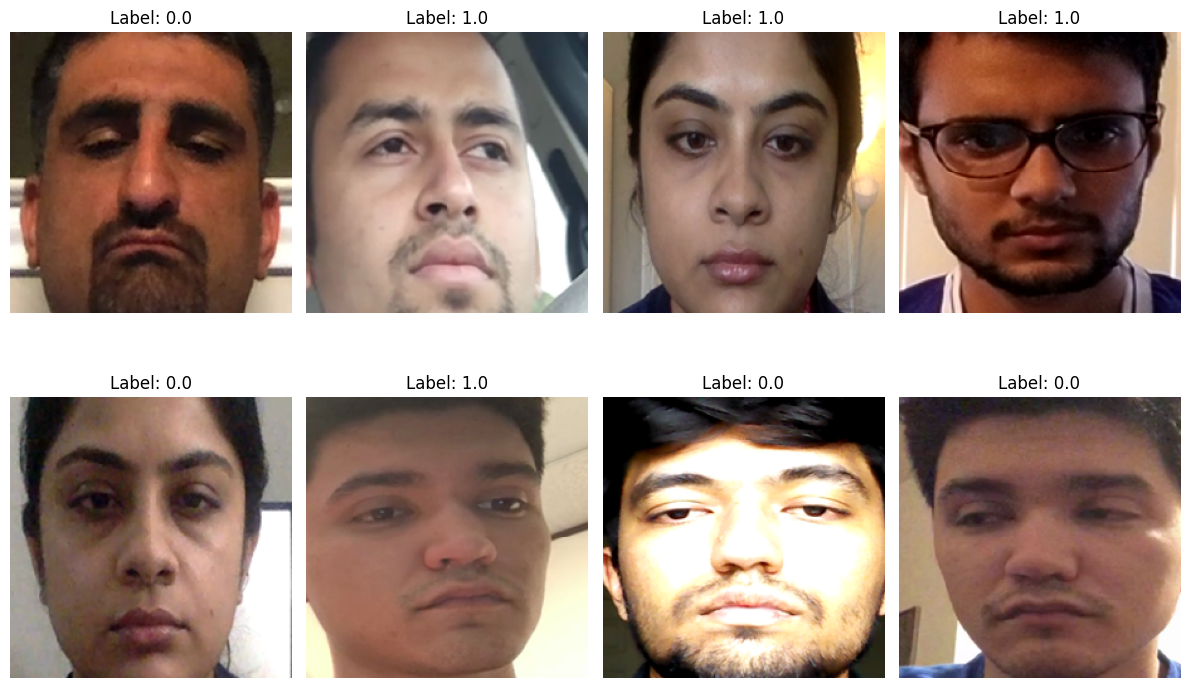

In [ ]:
sample_images, sample_labels = next(train_flow)
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
temporal_features = TimeDistributed(Flatten())(base_model.output)
sequence_processing = LSTM(128, return_sequences=True)(temporal_features)
dense_layer = Dense(1024, activation='relu')(sequence_processing)
feature_reduction = Dense(512, activation='relu')(dense_layer)
flattened = Flatten()(feature_reduction)
output_layer = Dense(2, activation='softmax')(flattened)

temporal_model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
temporal_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
training_log = temporal_model.fit(
    train_flow,
    epochs=2,
    validation_data=valid_flow,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 8173s 4s/step - accuracy: 0.9804 - loss: 0.0542 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 2/2
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 8100s 4s/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 9.2750e-04


In [ ]:
loss_train, acc_train = temporal_model.evaluate(train_flow)
print(f"\nTraining Results - Loss: {loss_train:.3f} | Accuracy: {acc_train*100:.1f}%")

loss_test, acc_test = temporal_model.evaluate(test_flow)
print(f"Test Results - Loss: {loss_test:.3f} | Accuracy: {acc_test*100:.1f}%")

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 6074s 3s/step - accuracy: 1.0000 - loss: 8.0164e-06

Training Results - Loss: 0.000 | Accuracy: 100.0%
131/131 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 1.0000 - loss: 1.5189e-05
Test Results - Loss: 0.000 | Accuracy: 100.0%


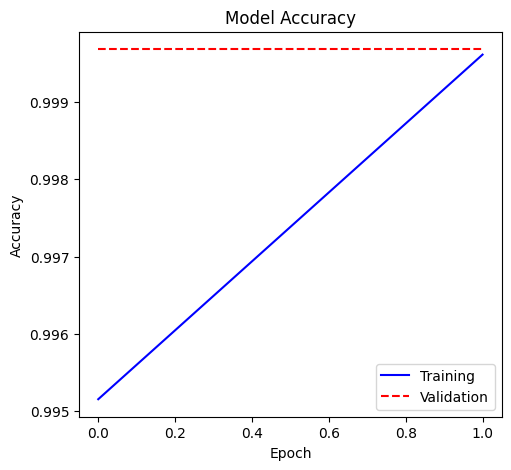

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_log.history['accuracy'], 'b-', label='Training')
plt.plot(training_log.history['val_accuracy'], 'r--', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

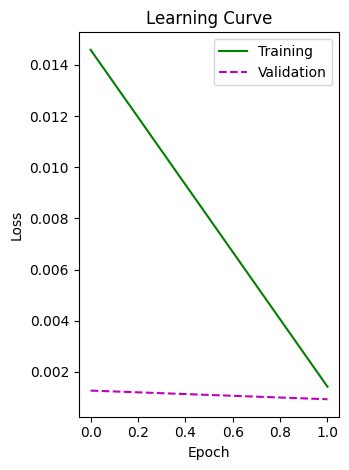

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(training_log.history['loss'], 'g-', label='Training')
plt.plot(training_log.history['val_loss'], 'm--', label='Validation')
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()